In [2]:
!pip install sensormotion

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sensormotion: filename=sensormotion-1.1.4-py3-none-any.whl size=19658 sha256=e600854fbce39c982a133ce087fa8f4cc9a1c3659dc889bf171a12dabe45836b
  Stored in directory: /root/.cache/pip/wheels/a2/a1/d6/d7229aff17b9a309282d830747f636814a3523178f171c7ffd
Successfully built sensormotion


In [7]:
"""
Calculate physical activity (PA) levels with conversion to activity counts.

Functions for converting raw sensor data to physical activity (PA) or
moderate-to-vigorous physical activity (MVPA) counts, similar to those given
by dedicated accelerometers such as Actigraph devices.

For a uniaxial accelerometer, the signal should first be passed into
:func:`sensormotion.pa.convert_counts`, then the counts should categorized
using :func:`sensormotion.pa.cut_points`.

For a triaxial accelerometer, an additional step is required. Each axis
should first be passed into :func:`sensormotion.pa.convert_counts` separately,
then the 3 count vectors should be passed into
:func:`sensormotion.signal.vector_magnitude` to calculate vector
magnitude (VM) of the counts. Finally, the single VM vector should be
categorized using :func:`sensormotion.pa.cut_points`.
"""

import matplotlib.pyplot as plt
import numpy as np
import sensormotion.signal

from scipy.integrate import simps, trapz


def convert_counts(
    x,
    time,
    time_scale="ms",
    epoch=60,
    rectify="full",
    integrate="simpson",
    plot=False,
    fig_size=(10, 5),
):
    """
    Convert acceleration to physical activity (PA) counts.

    Given an acceleration signal over a **single** axis, integrate the signal
    for each time window (epoch). The area under the curve for each epoch is
    the physical activity count for that time period.

    Linearly interpolated values are used if exact multiples of `epoch` are
    not found in the time signal.

    Parameters
    ----------
    x : ndarray
        Acceleration signal to be converted to PA counts.
    time : ndarray
        Time signal associated with `x`.
    time_scale : {'ms', 's'}, optional
        The unit that `time` is measured in. Either seconds (s) or
        milliseconds (ms).
    epoch : int, optional
        The duration of each time window in seconds. Counts will be calculated
        over this period. PA counts are usually measured over 60 second
        epochs. :func:`sensormotion.pa.cut_points` also requires 60 second
        epochs, however, if you're using your own cut point set and just want
        raw count values feel free to use any sized epoch.
    rectify : {'full', 'half'}, optional
        Type of rectifier to use on the input acceleration signal. This is to
        ensure that PA counts take into consideration negative acceleration
        values. Full-wave rectification turns all negative values into
        positive ones. Half-wave rectification sets all negative values to
        zero.
    integrate : {'simpson', 'trapezoid'}, optional
        Integration method to use for each epoch.
    plot : bool, optional
        Toggle to display a plot of PA counts over time.
    fig_size : tuple, optional
        If plotting, set the width and height of the resulting figure.

    Returns
    -------
    counts : ndarray
        PA count values for each epoch.
    """

    assert len(x) == len(time), "signal and time must be the same length"
    assert np.all(np.diff(time) > 0), "time signal is not fully ascending"
    assert (
        integrate == "simpson" or integrate == "trapezoid"
    ), "integrate method must either be simpson or trapezoid"

    x = np.asarray(x)
    time = np.asarray(time)

    # convert time to seconds
    if time_scale == "ms":
        time = time / 1000
    elif time_scale == "s":
        time = time

    # calculate time diff
    time = time - time[0]

    assert max(time) > epoch, "length of signal time shorter than epoch size"

    # rectify signal
    x = sensormotion.signal.rectify_signal(x, rectify)

    # interpolate missing times values to get exact epochs
    boundary_count = int(max(time) / epoch) + 1
    boundary_times = [i * epoch for i in range(boundary_count)]
    missing_times = np.setdiff1d(boundary_times, time)  # epoch times to interp

    x = np.append(x, np.interp(missing_times, time, x))  # interpolate x values
    time = np.append(time, missing_times)

    # sort new time and signal arrays together
    sort_idx = time.argsort()
    time = time[sort_idx]
    x = x[sort_idx]

    # get index of each epoch/boundary value for slicing
    boundary_idx = np.where(np.isin(time, boundary_times))[0]

    # integrate each epoch using Simpson's rule
    counts = np.ones(len(boundary_idx) - 1)  # preallocate array

    for i in range(len(counts)):
        lower = boundary_idx[i]
        upper = boundary_idx[i + 1] + 1  # upper bound should be inclusive

        cur_signal = x[lower:upper]
        cur_time = time[lower:upper]

        if integrate == "simpson":
            counts[i] = simps(cur_signal, cur_time)
        elif integrate == "trapezoid":
            counts[i] = trapz(cur_signal, cur_time)

    # plot counts
    if plot:
        f, ax = plt.subplots(1, 1, figsize=fig_size)

        ax.bar(boundary_times[1:], counts, width=epoch - 5)

        plt.xticks(
            boundary_times[1:],
            [
                "{} - {}".format(boundary_times[i], boundary_times[i + 1])
                for i, x in enumerate(boundary_times[1:])
            ],
        )

        for tick in ax.get_xticklabels():
            tick.set_rotation(45)

        plt.suptitle("Physical activity counts", size=16)
        plt.xlabel("Time window (seconds)")
        plt.ylabel("PA count")
        plt.show()

    return counts


def cut_points(x, set_name, n_axis, plot=False, fig_size=(10, 5)):
    """
    Categorize physical activity (PA) counts into intensity categories.

    Use a pre-specified cut-point set to determine the intensity level of each
    epoch of PA. Cut-point sets are from published research articles, and a
    summary can be found in the Actigraph FAQ:
    https://actigraph.desk.com/customer/en/portal/articles/2515803-what-s-the-difference-among-the-cut-points-available-in-actilife

    **Important**: The cut-point sets used here assume each count epoch is 60
    seconds long. If you're using counts from
    :func:`sensormotion.pa.convert_counts` make sure you had set the value of
    epoch to 60. Don't use this function if you use different length epochs.

    Parameters
    ----------
    x : ndarray
        Vector of counts calculated by :func:`sensormotion.pa.convert_counts`
        or vector magnitude from :func:`sensormotion.signal.vector_magnitude`.
        This can either be from a single axis or a vector magnitude, but set
        the `n_axis` parameter accordingly.
    set_name : {'butte_preschoolers', 'freedson_adult', 'freedson_children', 'keadle_women'}
        The name of the cut-point set to use.

        These are listed in the Actigraph FAQ, and the corresponding research
        article is shown below:

        `butte_preschoolers`: Butte et al. (2013) - Prediction of Energy
        Expenditure and Physical Activity in Preschoolers

        `freedson_adult` (uniaxial): Freedson et al. (1998) - Calibration of
        the Computer Science and Applications, Inc. accelerometer

        `freedson_adult` (triaxial): Freedson et al. (2011) - Validation and
        Comparison of ActiGraph Activity Monitors

        `freedson_children`: Freedson et al. (2005) - Calibration of
        accelerometer output for children

        `keadle_women`: Keadle et al. (2014) - Impact of accelerometer data
        processing decisions on the sample size, wear time and physical
        activity level of a large cohort study
    n_axis : {1, 3}
        Number of axes over which acceleration was recorded (1 = uniaxial,
        3 = triaxial accelerometer). This is used to determine the cut-point
        set values to use as some sets are for counts over a single axis,
        whereas others are thresholds for vector magnitude (calculated from
        3 axes).
    plot : bool, optional
        Toggle to display a plot of PA counts with category thresholds marked.
    fig_size : tuple, optional
        If plotting, set the width and height of the resulting figure.

    Returns
    -------
    category : list
        List of intensity categories for each epoch of PA, as determined by
        the cut-point set thresholds.
    time_spent : ndarray
        Amount of time (counts) spent at each PA intensity level.
    """

    # new cut-point sets should be added to this dictionary
    sets = {
        "butte_preschoolers": {
            1: {
                "sedentary": [-np.inf, 239],
                "light": [240, 2119],
                "moderate": [2120, 4449],
                "vigorous": [4450, np.inf],
            },
            3: {
                "sedentary": [-np.inf, 819],
                "light": [820, 3907],
                "moderate": [3908, 6111],
                "vigorous": [6112, np.inf],
            },
        },
        "freedson_adult": {
            1: {
                "sedentary": [-np.inf, 99],
                "light": [100, 1951],
                "moderate": [1952, 5724],
                "vigorous": [5725, 9498],
                "very vigorous": [9499, np.inf],
            },
            3: {
                "light": [-np.inf, 2690],
                "moderate": [2691, 6166],
                "vigorous": [6167, 9642],
                "very vigorous": [9643, np.inf],
            },
        },
        "freedson_children": {
            1: {
                "sedentary": [-np.inf, 149],
                "light": [150, 499],
                "moderate": [500, 3999],
                "vigorous": [4000, 7599],
                "very vigorous": [7600, np.inf],
            }
        },
        "keadle_women": {
            1: {
                "sedentary": [-np.inf, 99],
                "light": [100, 1951],
                "moderate": [1952, np.inf],
            },
            3: {
                "sedentary": [-np.inf, 199],
                "light": [200, 2689],
                "moderate": [2690, np.inf],
            },
        },
    }

    try:
        cur_set = sets[set_name][n_axis]
        print("Cut-point set: {} (axis count: {})...".format(set_name, n_axis))

        for i in cur_set:
            print("{}: {} to {}".format(i, cur_set[i][0], cur_set[i][1]))
    except KeyError:
        print(
            "Error: cut-point set not found. Make sure the set name and/or "
            "number of axes are correct"
        )
        raise

    # categorize counts
    category = []
    for count in x:
        for intensity in cur_set:
            if cur_set[intensity][0] <= count <= cur_set[intensity][1]:
                category.append(intensity)
                break

    # count time spent
    category_unique, category_count = np.unique(category, return_counts=True)
    time_spent = np.asarray((category_unique, category_count))

    # plot counts with intensity categories
    if plot:
        boundaries = [(item, cur_set[item][0]) for item in cur_set]
        boundaries.sort(key=lambda x: x[1])

        f, ax = plt.subplots(1, 1, figsize=fig_size)

        ax.bar(range(1, len(x) + 1), x)

        for line in boundaries[1:]:
            if line[1] < max(x):
                plt.axhline(line[1], linewidth=1, linestyle="--", color="k")
                t = plt.text(0.4, line[1], line[0], backgroundcolor="w")
                t.set_bbox(dict(facecolor="w", edgecolor="k"))

        plt.xticks(range(1, len(x) + 1))

        plt.suptitle("Physical activity counts and intensity", size=16)
        plt.xlabel("Epoch (length: 60 seconds)")
        plt.ylabel("PA count")
        plt.show()

    return category, time_spent

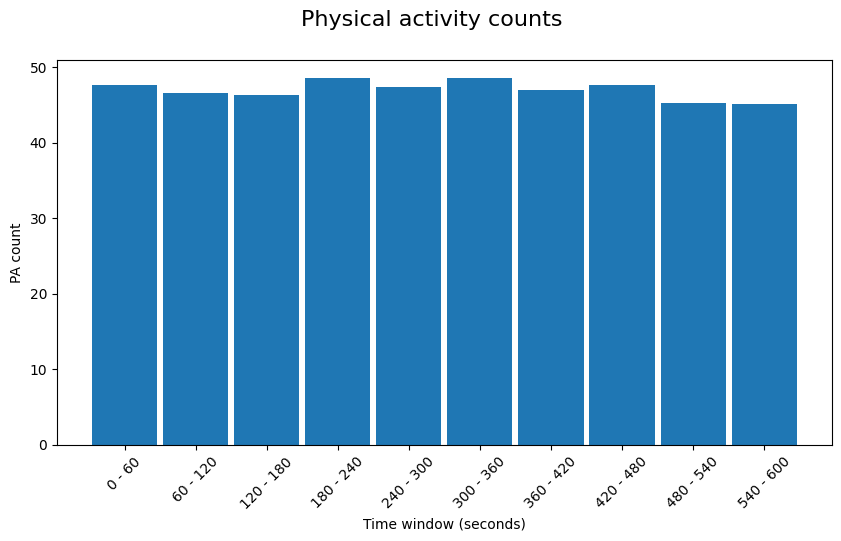

Cut-point set: freedson_adult (axis count: 1)...
sedentary: -inf to 99
light: 100 to 1951
moderate: 1952 to 5724
vigorous: 5725 to 9498
very vigorous: 9499 to inf


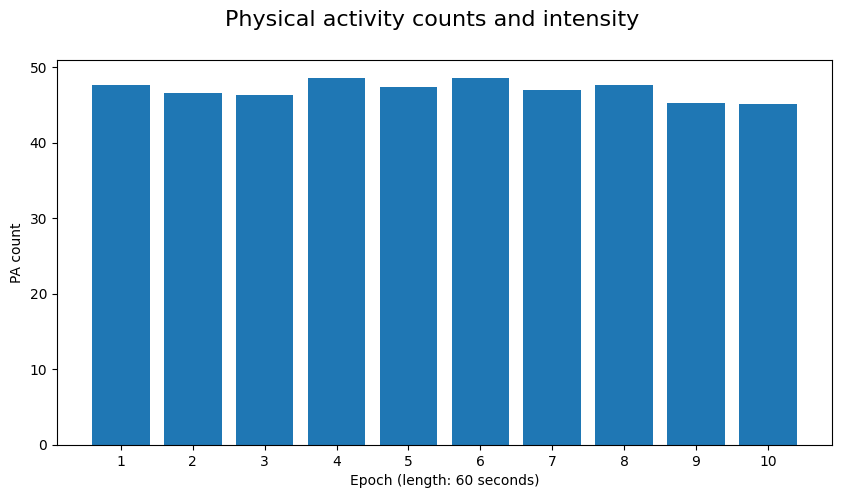

Intensity categories: ['sedentary', 'sedentary', 'sedentary', 'sedentary', 'sedentary', 'sedentary', 'sedentary', 'sedentary', 'sedentary', 'sedentary']
Time spent at each intensity level: [['sedentary']
 ['10']]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sensormotion.pa

# Generate sample data
time = np.linspace(0, 600, 6000)  # 10 minutes with 100 Hz sampling rate
acceleration = np.random.randn(len(time))  # Random acceleration values

# Convert acceleration to PA counts
counts = sensormotion.pa.convert_counts(
    acceleration,
    time,
    time_scale="s",
    epoch=60,
    rectify="full",
    integrate="simpson",
    plot=True,
    fig_size=(10, 5),
)

# Categorize PA counts into intensity categories
category, time_spent = sensormotion.pa.cut_points(
    counts,
    set_name="freedson_adult",
    n_axis=1,
    plot=True,
    fig_size=(10, 5),
)

print("Intensity categories:", category)
print("Time spent at each intensity level:", time_spent)
